This is one of the Objectiv [example notebooks](https://objectiv.io/docs/modeling/example-notebooks/). These notebooks can run [on your own data](https://objectiv.io/docs/modeling/get-started-in-your-notebook/), or you can instead run the [Demo](https://objectiv.io/docs/home/try-the-demo/) to quickly try them out.

# Open Model Hub basics
This example notebook demonstrates how you can use the pre-built models from the [open model hub](https://objectiv.io/docs/modeling/) in conjunction with modeling library [Bach](https://objectiv.io/docs/modeling/bach/) to quickly build model stacks to answer common analytics questions.

For more background and an overview of all available models, see the [open model hub documentation](https://objectiv.io/docs/modeling/open-model-hub/), and [see here how to get started in your own notebook](https://objectiv.io/docs/modeling/get-started-in-your-notebook/).

## Using the Open Model Hub
The following types of functions/models are provided:

1. [Helper functions](https://objectiv.io/docs/modeling/open-model-hub/models/helper-functions/): Simplify manipulating and analyzing the data.
2. [Aggregation models](https://objectiv.io/docs/modeling/open-model-hub/models/aggregation/): Enable running some of the more common data analyses and product analytics metrics.
3. [Machine learning models](https://objectiv.io/docs/modeling/open-model-hub/models/machine-learning/): ML models such as logistic regression.
4. [Funnels](https://objectiv.io/docs/modeling/open-model-hub/models/funnels/): To analyze Funnels, e.g. discover all the (top) user journeys that lead to conversion or drop-off.

Modeling behavior of users and groups is enabled through configurable [Identity Resolution](https://objectiv.io/docs/modeling/open-model-hub/identity-resolution/).

**Helper functions** always return a [Series](https://objectiv.io/docs/modeling/bach/api-reference/Series/) with the same shape and index as the [DataFrame](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/) they are applied to. This ensures they can be added as a column to that [DataFrame](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/). Helper functions that return [SeriesBoolean](https://objectiv.io/docs/modeling/bach/api-reference/Series/Boolean/) can be used to filter the data. The helper functions can be accessed with the `map` accessor from a model hub instance.

**Aggregation models** perform multiple [Bach](https://objectiv.io/docs/modeling/bach/) instructions that run some of the more common data analyses and product analytics metrics. They always return aggregated data in some form from the [DataFrame](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/) they're applied to. Aggregation models can be accessed with the `aggregate` accessor from a model hub instance.

Most of the model hub helper functions and aggregation models take `data` as their first argument: this is
the [DataFrame](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/) with the Objectiv data to apply the model to. 

For an example of a **machine learning model**, see the [logistic regression example notebook](https://objectiv.io/docs/modeling/example-notebooks/logistic-regression/).

Below we'll showcase a selection of the models from the open model hub.

## Get started
We first have to instantiate the model hub and an Objectiv DataFrame object.

In [1]:
# set the timeframe of the analysis
start_date = '2022-03-01'
end_date = None

In [2]:
from modelhub import ModelHub, display_sql_as_markdown

# instantiate the model hub and set the default time aggregation to daily
# and set the global contexts that will be used in this example
modelhub = ModelHub(time_aggregation='%Y-%m-%d', global_contexts=['application'])
# get a Bach DataFrame with Objectiv data within a defined timeframe
df = modelhub.get_objectiv_dataframe(start_date=start_date, end_date=end_date)

### Reference
* [modelhub.ModelHub](https://objectiv.io/docs/modeling/open-model-hub/api-reference/ModelHub/ModelHub/)
* [modelhub.ModelHub.get_objectiv_dataframe](https://objectiv.io/docs/modeling/open-model-hub/api-reference/ModelHub/get_objectiv_dataframe/)

## Run a simple aggregation model
Calculating the number of unique users is one of the models. As it is an aggregation model, it's called with [`model_hub.aggregate.unique_users()`](https://objectiv.io/docs/modeling/open-model-hub/models/aggregation/unique_users/) (or `model_hub.agg.unique_users()` for short). It uses the `time_aggregation` that is set when the model hub was instantiated. 

With [`.head()`](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/head/) we immediately query the data to show the results. [`.to_pandas()`](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/to_pandas/) can be used to use all results as a pandas object in Python. These (and the following) results are sorted descending, so we show the latest data first.

In [3]:
# calculate the unique users per set time_aggregation (in this case per day)
users = modelhub.aggregate.unique_users(df)
users.sort_index(ascending=False).head(10)

time_aggregation
2022-09-21     1
2022-09-20     1
2022-08-09    25
2022-08-08    48
2022-08-07    19
2022-08-06    16
2022-08-05    33
2022-08-04    64
2022-08-03    38
2022-08-02    44
Name: unique_users, dtype: int64

### Reference
* [modelhub.Aggregate.unique_users](https://objectiv.io/docs/modeling/open-model-hub/models/aggregation/unique_users/)
* [bach.DataFrame.sort_index](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/sort_index/)
* [bach.DataFrame.head](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/head/)

## Mapping and filtering
Here we'll use `map` operations from the open model hub to label certain users or events, in order to filter on them or combine them with other models later on.

First, we'll label users as being a new user. As `time_aggregation` was set to '%Y-%m-%d' it means all hits are labeled as new for the entire day in which the user had its first session.

In [4]:
# label new users & all their events on the defined time_aggregation 
df['is_new_user'] = modelhub.map.is_new_user(df)
df.is_new_user.head(10)

event_id
a6629a25-54ec-4cc5-a84a-2440164a0779    True
94fa97a3-5623-4b7c-b953-79c9971f4e53    True
0041d6c0-af21-4a30-9374-09056b535cfc    True
4a957bb2-1b2c-4130-a14f-4f2c11532633    True
592c232e-5ce4-4ae7-a22a-91daf2d61264    True
1ec47a29-718d-4b26-bbfa-2b4527918d9d    True
4758a819-2bbc-4df3-919f-a297a19170c7    True
69ff04f5-3c50-4a77-acb6-8e26630c209a    True
fa5c7adb-a37b-4693-a593-33f1b998f0da    True
ed2ccacb-7a27-4966-803c-55630612abb0    True
Name: is_new_user, dtype: bool

We can also label conversion events. To do this, we first have to define what a conversion is, by setting the type of event and the location in the product where the event was triggered ([see more about the location stack here](https://objectiv.io/docs/modeling/example-notebooks/open-taxonomy/#location-stack-and-global-contexts)), using [`add_conversion_event`](https://objectiv.io/docs/modeling/open-model-hub/api-reference/ModelHub/add_conversion_event/).

In [5]:
# define a conversion event, and label events whether they converted
modelhub.add_conversion_event(location_stack=df.location_stack.json[{'id': 'Quickstart Guide', '_type': 'LinkContext'}:],
                              event_type='PressEvent',
                              name='quickstart_presses')
df['conversion_events'] = modelhub.map.is_conversion_event(df, 'quickstart_presses')
df.conversion_events.head(10)

event_id
a6629a25-54ec-4cc5-a84a-2440164a0779    False
94fa97a3-5623-4b7c-b953-79c9971f4e53    False
0041d6c0-af21-4a30-9374-09056b535cfc    False
4a957bb2-1b2c-4130-a14f-4f2c11532633    False
592c232e-5ce4-4ae7-a22a-91daf2d61264    False
1ec47a29-718d-4b26-bbfa-2b4527918d9d    False
4758a819-2bbc-4df3-919f-a297a19170c7    False
69ff04f5-3c50-4a77-acb6-8e26630c209a    False
fa5c7adb-a37b-4693-a593-33f1b998f0da    False
ed2ccacb-7a27-4966-803c-55630612abb0    False
Name: conversion_events, dtype: bool

### Combine mapping with filtering and aggregation
As the map functions above return a SeriesBoolean, they can be combined with filter and aggregation models. We use the same aggregation model we showed earlier ([`unique_users`](https://objectiv.io/docs/modeling/open-model-hub/models/aggregation/unique_users/)), but now applying the `df.conversion_events` filter to just look at unique converted users per day.

In [6]:
# filter unique users on whether they've converted
modelhub.aggregate.unique_users(df[df.conversion_events]).sort_index(ascending=False).head(10)

time_aggregation
2022-06-13    1
2022-06-12    2
2022-06-10    2
2022-06-09    3
2022-06-08    4
2022-06-07    3
2022-06-06    1
2022-06-04    1
2022-06-03    2
2022-05-31    1
Name: unique_users, dtype: int64

Other aggregation models can be used similarly. In the example below, the average session duration is calculated just for new users.

In [7]:
# calculate average session duration, filtered on new users
duration_new_users = modelhub.aggregate.session_duration(df[df.is_new_user])
duration_new_users.sort_index(ascending=False).head(10)

time_aggregation
2022-09-20   0 days 00:08:38.721000
2022-08-09   0 days 00:00:40.306857
2022-08-08   0 days 00:05:03.880000
2022-08-07   0 days 00:02:20.172875
2022-08-06   0 days 00:02:40.904800
2022-08-05   0 days 00:02:20.575867
2022-08-04   0 days 00:02:40.554209
2022-08-03   0 days 00:01:37.521500
2022-08-02   0 days 00:01:51.257320
2022-08-01   0 days 00:02:11.933519
Name: session_duration, dtype: timedelta64[ns]

### Using multiple model hub filters

The model hub's `map` results can be combined and reused. Below we set the result of two helper functions as a column to the original DataFrame, and use them both to filter the data and apply an aggregation model. We calculate the number of users that were new in a month, and also the number of users that converted twice on a day.

In [8]:
# calculate new users & users that converted twice on a day
df['is_new_user_month'] = modelhub.map.is_new_user(df, time_aggregation = '%Y-%m')
df['is_twice_converted'] = modelhub.map.conversions_in_time(df, name='quickstart_presses')==2
# use results in an aggregation model
modelhub.aggregate.unique_users(df[df.is_new_user_month & df.is_twice_converted]).sort_index(ascending=False).head()

time_aggregation
2022-06-07    1
2022-06-04    1
2022-05-29    1
2022-05-26    1
2022-05-24    1
Name: unique_users, dtype: int64

### Reference
* [modelhub.Map.is_new_user](https://objectiv.io/docs/modeling/open-model-hub/models/helper-functions/is_new_user/)
* [bach.DataFrame.head](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/head/)
* [modelhub.ModelHub.add_conversion_event](https://objectiv.io/docs/modeling/open-model-hub/api-reference/ModelHub/add_conversion_event/)
* [modelhub.Map.is_conversion_event](https://objectiv.io/docs/modeling/open-model-hub/models/helper-functions/is_conversion_event/)
* [modelhub.Aggregate.unique_users](https://objectiv.io/docs/modeling/open-model-hub/models/aggregation/unique_users/)
* [modelhub.Aggregate.session_duration](https://objectiv.io/docs/modeling/open-model-hub/models/aggregation/session_duration/)
* [modelhub.Map.conversions_in_time](https://objectiv.io/docs/modeling/open-model-hub/models/helper-functions/conversions_in_time/)
* [bach.DataFrame.sort_index](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/sort_index/)

## Combine model results
Results from aggregation models can be used together if they share the same index type - similar to pandas. Below the share of new users per day is calculated.

In [9]:
# calculate the share of new users per day using results from two aggregation models
new_user_share = modelhub.agg.unique_users(df[df.is_new_user]) / modelhub.agg.unique_users(df)
new_user_share.sort_index(ascending=False).head(10)

time_aggregation
2022-09-21         NaN
2022-09-20    1.000000
2022-08-09    0.800000
2022-08-08    0.812500
2022-08-07    0.736842
2022-08-06    0.937500
2022-08-05    0.696970
2022-08-04    0.875000
2022-08-03    0.815789
2022-08-02    0.863636
Name: unique_users, dtype: float64

### Reference
* [modelhub.Aggregate.unique_users](https://objectiv.io/docs/modeling/open-model-hub/models/aggregation/unique_users/)
* [modelhub.Map.is_new_user](https://objectiv.io/docs/modeling/open-model-hub/models/helper-functions/is_new_user/)
* [bach.DataFrame.sort_index](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/sort_index/)
* [bach.DataFrame.head](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/head/)

## Crunch data further with the Bach modeling library
All results from the model hub are in the form of a Bach [DataFrame](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/) or [Series](https://objectiv.io/docs/modeling/bach/api-reference/Series/). This makes the open model hub and Bach work seamlessly together.

In [10]:
# We'll do a lot of operations on the data in the df DataFrame. To make this easier for the
# database (especially BigQuery), we tell Bach to materialize the current DataFrame as temporary
# table. This statement has no direct effect, but any invocation of head() on the DataFrame later
# on will consist of two queries: one to create a temporary table with the current state of the
# DataFrame, and one that queries that table and does subsequent operations.
df = df.materialize(materialization='temp_table')

In [11]:
# now label the number of times a user is converted in a session at a certain moment
df['conversion_count'] = modelhub.map.conversions_in_time(df, name='quickstart_presses')

# use Bach to do any supported operation using pandas syntax.
# select users that converted
converted_users = df[df.conversion_events].user_id.unique()
# select PressEvents of users that converted
df_selection = df[(df.event_type == 'PressEvent') &
                  (df.user_id.isin(converted_users))]
# calculate the number of PressEvents before conversion per session
presses_per_session = df_selection[df_selection.conversion_count == 0].groupby('session_id').session_hit_number.count()

Now let's see the results, at which point the underlying query is actually executed.

In [12]:
presses_per_session.head()

session_id
6     2
10    2
11    1
16    1
23    2
Name: session_hit_number, dtype: int64

See the [Bach API reference](https://objectiv.io/docs/modeling/bach/api-reference/) for all available operations.

### Reference
* [bach.DataFrame.materialize](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/materialize/)
* [modelhub.Map.conversions_in_time](https://objectiv.io/docs/modeling/open-model-hub/models/helper-functions/conversions_in_time/)
* [bach.Series.unique](https://objectiv.io/docs/modeling/bach/api-reference/Series/unique/)
* [bach.Series.isin](https://objectiv.io/docs/modeling/bach/api-reference/Series/isin/)
* [bach.DataFrame.groupby](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/groupby/)
* [bach.DataFrame.head](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/head/)

## Export results to a pandas DataFrame
Bach DataFrames and/or model hub results can always be exported to pandas, so you can use all its options as well as pandas-compatible ML packages. Since Bach DataFrame operations run on the full dataset in the SQL data store, it is recommended to export to pandas if the data is small enough, i.e. by aggregation or selection.

Below we plot the previously calculated presses per session before conversion, using pandas' built-in plotting methods.

<AxesSubplot: >

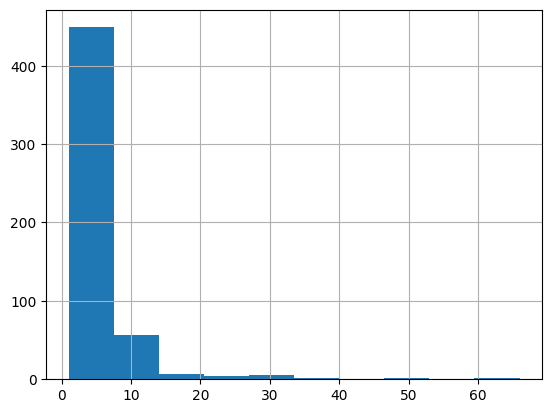

In [13]:
# presses_per_session_pd is a pandas Series
presses_per_session_pd = presses_per_session.to_pandas()
presses_per_session_pd.hist()

### Reference
* [bach.DataFrame.to_pandas](https://objectiv.io/docs/modeling/bach/api-reference/DataFrame/to_pandas/)

## Get the SQL for any analysis
The SQL for any analysis can be exported with one command, so you can use models in production directly to simplify data debugging & delivery to BI tools like Metabase, dbt, etc. See how you can [quickly create BI dashboards with this](https://objectiv.io/docs/home/try-the-demo#creating-bi-dashboards).

In [14]:
# show SQL for analysis; this is just one example, and works for any Objectiv model/analysis
# complex SQL statement alert!
display_sql_as_markdown(new_user_share)

```sql
WITH "manual_materialize___e627e9bdda472e6a76c583c57c6d37ed" AS (
        SELECT "event_id" AS "event_id",
               "day" AS "day",
               "moment" AS "moment",
               "cookie_id" AS "user_id",
               "value"->>'_type' AS "event_type",
               cast("value"->>'_types' AS JSONB) AS "stack_event_types",
               cast("value"->>'location_stack' AS JSONB) AS "location_stack",
               cast("value"->>'time' AS bigint) AS "time",
               jsonb_path_query_array(cast("value"->>'global_contexts' AS JSONB), '$[*] ? (@._type == $type)', '{"type":"ApplicationContext"}') AS "application"
          FROM "data"
       ),
       "getitem_where_boolean___f2cde873eb364f71fe22bb16f7c0d3b2" AS (
        SELECT "event_id" AS "event_id",
               "day" AS "day",
               "moment" AS "moment",
               "user_id" AS "user_id",
               "event_type" AS "event_type",
               "stack_event_types" AS "stack_event_types",
               "location_stack" AS "location_stack",
               "time" AS "time",
               "application" AS "application"
          FROM "manual_materialize___e627e9bdda472e6a76c583c57c6d37ed"
         WHERE ("day" >= cast('2022-03-01' AS date))
       ),
       "context_data___d327b0c80890ea30396586d79ce32be4" AS (
        SELECT "event_id" AS "event_id",
               "day" AS "day",
               "moment" AS "moment",
               "user_id" AS "user_id",
               "location_stack" AS "location_stack",
               "event_type" AS "event_type",
               "stack_event_types" AS "stack_event_types",
               "application" AS "application"
          FROM "getitem_where_boolean___f2cde873eb364f71fe22bb16f7c0d3b2"
       ),
       "session_starts___696546caa41f41b7d73bbf427a070804" AS (
        SELECT "event_id" AS "event_id",
               "day" AS "day",
               "moment" AS "moment",
               "user_id" AS "user_id",
               "location_stack" AS "location_stack",
               "event_type" AS "event_type",
               "stack_event_types" AS "stack_event_types",
               "application" AS "application",
               CASE WHEN (extract(epoch FROM (("moment") - (lag("moment", 1, cast(NULL AS TIMESTAMP WITHOUT TIME ZONE)) OVER (PARTITION BY "user_id" ORDER BY "moment" ASC NULLS LAST, "event_id" ASC NULLS LAST RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)))) <= cast(1800 AS bigint)) THEN cast(NULL AS boolean)
                    ELSE cast(TRUE AS boolean)
                     END AS "is_start_of_session"
          FROM "context_data___d327b0c80890ea30396586d79ce32be4"
       ),
       "session_id_and_count___a779ca58890dc0f5d6f2c49f36244cf2" AS (
        SELECT "event_id" AS "event_id",
               "day" AS "day",
               "moment" AS "moment",
               "user_id" AS "user_id",
               "location_stack" AS "location_stack",
               "event_type" AS "event_type",
               "stack_event_types" AS "stack_event_types",
               "application" AS "application",
               "is_start_of_session" AS "is_start_of_session",
               CASE WHEN "is_start_of_session" THEN row_number() OVER (PARTITION BY "is_start_of_session" ORDER BY "moment" ASC NULLS LAST, "event_id" ASC NULLS LAST RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)
                    ELSE cast(NULL AS bigint)
                     END AS "session_start_id",
               count("is_start_of_session") OVER (ORDER BY "user_id" ASC NULLS LAST, "moment" ASC NULLS LAST, "event_id" ASC NULLS LAST RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS "is_one_session"
          FROM "session_starts___696546caa41f41b7d73bbf427a070804"
       ),
       "objectiv_sessionized_data___22729f63a942dd9a044e7c5e20997edf" AS (
        SELECT "event_id" AS "event_id",
               "day" AS "day",
               "moment" AS "moment",
               "user_id" AS "user_id",
               "location_stack" AS "location_stack",
               "event_type" AS "event_type",
               "stack_event_types" AS "stack_event_types",
               "application" AS "application",
               "is_start_of_session" AS "is_start_of_session",
               "session_start_id" AS "session_start_id",
               "is_one_session" AS "is_one_session",
               first_value("session_start_id") OVER (PARTITION BY "is_one_session" ORDER BY "moment" ASC NULLS LAST, "event_id" ASC NULLS LAST RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS "session_id",
               row_number() OVER (PARTITION BY "is_one_session" ORDER BY "moment" ASC NULLS LAST, "event_id" ASC NULLS LAST RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS "session_hit_number"
          FROM "session_id_and_count___a779ca58890dc0f5d6f2c49f36244cf2"
       ),
       "manual_materialize___fb7e49e2bf44811deda81920e017f117" AS (
        SELECT "event_id" AS "event_id",
               (min("session_id") OVER (PARTITION BY to_char("moment", 'YYYY"-"MM"-"DD'), "user_id" ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) = min("session_id") OVER (PARTITION BY "user_id" ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)) AS "is_new_user"
          FROM "objectiv_sessionized_data___22729f63a942dd9a044e7c5e20997edf"
       ),
       "merge_sql___29bce09e437b81cf334d66f5cfe92107" AS (
        SELECT COALESCE("l"."event_id", "r"."event_id") AS "event_id",
               "l"."day" AS "day",
               "l"."moment" AS "moment",
               "l"."user_id" AS "user_id",
               "l"."location_stack" AS "location_stack",
               "l"."event_type" AS "event_type",
               "l"."stack_event_types" AS "stack_event_types",
               "l"."session_id" AS "session_id",
               "l"."session_hit_number" AS "session_hit_number",
               "l"."application" AS "application",
               "r"."is_new_user" AS "is_new_user"
          FROM "objectiv_sessionized_data___22729f63a942dd9a044e7c5e20997edf" AS l
          LEFT
            JOIN "manual_materialize___fb7e49e2bf44811deda81920e017f117" AS r
            ON ("l"."event_id" = "r"."event_id")
       ),
       "manual_materialize___6c51323f87cadd728f2d2acce7504643" AS (
        SELECT "event_id" AS "event_id",
               (min("session_id") OVER (PARTITION BY to_char("moment", 'YYYY"-"MM'), "user_id" ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) = min("session_id") OVER (PARTITION BY "user_id" ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)) AS "is_new_user"
          FROM "merge_sql___29bce09e437b81cf334d66f5cfe92107"
       ),
       "merge_sql___6d76b439e43d4f5fa6821f70398d4aaa" AS (
        SELECT COALESCE("l"."event_id", "r"."event_id") AS "event_id",
               "l"."day" AS "day",
               "l"."moment" AS "moment",
               "l"."user_id" AS "user_id",
               "l"."location_stack" AS "location_stack",
               "l"."event_type" AS "event_type",
               "l"."stack_event_types" AS "stack_event_types",
               "l"."session_id" AS "session_id",
               "l"."session_hit_number" AS "session_hit_number",
               "l"."application" AS "application",
               "l"."is_new_user" AS "is_new_user",
               (((jsonb_array_length(coalesce((SELECT jsonb_agg(x.value) FROM jsonb_array_elements("l"."location_stack") WITH ORDINALITY x WHERE ORDINALITY - 1 >= (SELECT min(CASE WHEN ('{"id": "Quickstart Guide", "_type": "LinkContext"}'::JSONB) <@ value THEN ORDINALITY END) -1 FROM jsonb_array_elements("l"."location_stack") WITH ORDINALITY)), '[]'::JSONB)) > cast(0 AS bigint))) AND (("l"."event_type" = 'PressEvent'))) AS "conversion_events",
               "r"."is_new_user" AS "is_new_user_month"
          FROM "merge_sql___29bce09e437b81cf334d66f5cfe92107" AS l
          LEFT
            JOIN "manual_materialize___6c51323f87cadd728f2d2acce7504643" AS r
            ON ("l"."event_id" = "r"."event_id")
       ),
       "merge_sql___8d2bab37506e8eff97b33ebdb554e4a5" AS (
        SELECT COALESCE("l"."event_id", "r"."event_id") AS "event_id",
               (jsonb_array_length(coalesce((SELECT jsonb_agg(x.value) FROM jsonb_array_elements("l"."location_stack") WITH ORDINALITY x WHERE ORDINALITY - 1 >= (SELECT min(CASE WHEN ('{"id": "Quickstart Guide", "_type": "LinkContext"}'::JSONB) <@ value THEN ORDINALITY END) -1 FROM jsonb_array_elements("l"."location_stack") WITH ORDINALITY)), '[]'::JSONB)) > cast(0 AS bigint)) AS "location_stack",
               ("r"."event_type" = 'PressEvent') AS "event_type"
          FROM "merge_sql___29bce09e437b81cf334d66f5cfe92107" AS l
          FULL OUTER
            JOIN "merge_sql___6d76b439e43d4f5fa6821f70398d4aaa" AS r
            ON ("l"."event_id" = "r"."event_id")
       ),
       "merge_sql___8933d7d516a8189ef8d179a8e4303e0b" AS (
        SELECT COALESCE("l"."event_id", "r"."event_id") AS "event_id",
               "l"."moment" AS "moment",
               "l"."event_type" AS "event_type",
               "l"."session_id" AS "session_id",
               (("r"."location_stack") AND ("r"."event_type")) AS "__is_conversion_event"
          FROM "merge_sql___6d76b439e43d4f5fa6821f70398d4aaa" AS l
          LEFT
            JOIN "merge_sql___8d2bab37506e8eff97b33ebdb554e4a5" AS r
            ON ("l"."event_id" = "r"."event_id")
       ),
       "conversions_in_time_calculat___f090bef0d1e8e3df4779080d3ff5b9e4" AS (
        SELECT "event_id" AS "event_id",
               "moment" AS "moment",
               "event_type" AS "event_type",
               "session_id" AS "session_id",
               "__is_conversion_event" AS "__is_conversion_event",
               CASE WHEN "__is_conversion_event" THEN cast(1 AS bigint)
                    ELSE cast(0 AS bigint)
                     END AS "__conversion_counter",
               cast(sum(CASE WHEN "__is_conversion_event" THEN cast(1 AS bigint) ELSE cast(0 AS bigint) END) OVER (PARTITION BY "session_id" ORDER BY "session_id" ASC NULLS LAST, "moment" ASC NULLS LAST RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS bigint) AS "__conversions_in_time"
          FROM "merge_sql___8933d7d516a8189ef8d179a8e4303e0b"
       ),
       "merge_sql___7ac0a1ecbfa037c088d88c33644e8460" AS (
        SELECT COALESCE("l"."event_id", "r"."event_id") AS "event_id",
               "l"."day" AS "day",
               "l"."moment" AS "moment",
               "l"."user_id" AS "user_id",
               "l"."location_stack" AS "location_stack",
               "l"."event_type" AS "event_type",
               "l"."stack_event_types" AS "stack_event_types",
               "l"."session_id" AS "session_id",
               "l"."session_hit_number" AS "session_hit_number",
               "l"."application" AS "application",
               "l"."is_new_user" AS "is_new_user",
               "l"."conversion_events" AS "conversion_events",
               "l"."is_new_user_month" AS "is_new_user_month",
               ("r"."__conversions_in_time" = cast(2 AS bigint)) AS "is_twice_converted"
          FROM "merge_sql___6d76b439e43d4f5fa6821f70398d4aaa" AS l
          LEFT
            JOIN "conversions_in_time_calculat___f090bef0d1e8e3df4779080d3ff5b9e4" AS r
            ON ("l"."event_id" = "r"."event_id")
       ),
       "getitem_where_boolean___c7b518cb10a086644d9c228dd3f7ee8f" AS (
        SELECT "event_id" AS "event_id",
               "day" AS "day",
               "moment" AS "moment",
               "user_id" AS "user_id",
               "location_stack" AS "location_stack",
               "event_type" AS "event_type",
               "stack_event_types" AS "stack_event_types",
               "session_id" AS "session_id",
               "session_hit_number" AS "session_hit_number",
               "application" AS "application",
               "is_new_user" AS "is_new_user",
               "conversion_events" AS "conversion_events",
               "is_new_user_month" AS "is_new_user_month",
               "is_twice_converted" AS "is_twice_converted"
          FROM "merge_sql___7ac0a1ecbfa037c088d88c33644e8460"
         WHERE "is_new_user"
       ),
       "merge_left___19c9eb3a7c4d4ed18d0fa7cf24216b89" AS (
        SELECT to_char("moment", 'YYYY"-"MM"-"DD') AS "time_aggregation",
               cast(count(DISTINCT "user_id") AS double precision) AS "unique_users"
          FROM "getitem_where_boolean___c7b518cb10a086644d9c228dd3f7ee8f"
         GROUP BY to_char("moment", 'YYYY"-"MM"-"DD')
       ),
       "manual_materialize___3ffabf4a179a35a2cd52314b5a678005" AS (
        SELECT to_char("moment", 'YYYY"-"MM"-"DD') AS "time_aggregation",
               count(DISTINCT "user_id") AS "unique_users"
          FROM "merge_sql___7ac0a1ecbfa037c088d88c33644e8460"
         GROUP BY to_char("moment", 'YYYY"-"MM"-"DD')
       ),
       "merge_sql___830070d26a1594213957d60a528bbebc" AS (
        SELECT COALESCE("l"."time_aggregation", "r"."time_aggregation") AS "time_aggregation",
               "l"."unique_users" AS "unique_users",
               "r"."unique_users" AS "unique_users__other"
          FROM "merge_left___19c9eb3a7c4d4ed18d0fa7cf24216b89" AS l
          FULL OUTER
            JOIN "manual_materialize___3ffabf4a179a35a2cd52314b5a678005" AS r
            ON ("l"."time_aggregation" = "r"."time_aggregation")
       ) SELECT "time_aggregation" AS "time_aggregation",
       ("unique_users" / "unique_users__other") AS "unique_users"
  FROM "merge_sql___830070d26a1594213957d60a528bbebc"
```

That's it! [Join us on Slack](https://objectiv.io/join-slack) if you have any questions or suggestions.

# Next Steps

### Use this notebook with your own data

You can use the example notebooks on any dataset that was collected with Objectiv's tracker, so feel free to 
use them to bootstrap your own projects. They are available as Jupyter notebooks on our [GitHub repository](https://github.com/objectiv/objectiv-analytics/tree/main/notebooks). See [instructions to set up the Objectiv tracker](https://objectiv.io/docs/tracking/).

### Check out related example notebooks

* [Open taxonomy how-to](https://objectiv.io/docs/modeling/example-notebooks/open-taxonomy/) - see what you can do with the Bach modeling library and a dataset that is validated against the open analytics taxonomy.

* [Explore your data](https://objectiv.io/docs/modeling/example-notebooks/explore-data/) - see how you can easily explore your data collected with Objectiv.